# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки  
**DateCrawled** — дата скачивания анкеты из базы  
**VehicleType** — тип автомобильного кузова  
**RegistrationYear** — год регистрации автомобиля  
**Gearbox**— тип коробки передач  
**Power** — мощность (л. с.)  
**Model** — модель автомобиля  
**Kilometer** — пробег (км)  
**RegistrationMonth** — месяц регистрации автомобиля  
**FuelType** — тип топлива  
**Brand** — марка автомобиля  
**Repaired** — была машина в ремонте или нет  
**DateCreated** — дата создания анкеты  
**NumberOfPictures** — количество фотографий автомобиля  
**PostalCode** — почтовый индекс владельца анкеты (пользователя)  
**LastSeen** — дата последней активности пользователя  
Целевой признак  
**Price** — цена (евро)  

## Подготовка данных

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RANDOM_STATE = 12345

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
26205,2016-03-09 18:54:35,1400,sedan,2002,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-09 00:00:00,0,8258,2016-03-26 04:45:34
54326,2016-03-05 19:36:23,1199,small,2000,manual,105,3er,150000,4,petrol,bmw,no,2016-03-05 00:00:00,0,76846,2016-03-31 11:43:50
321899,2016-03-10 12:53:56,1900,small,2001,manual,75,clio,100000,9,petrol,renault,NaN,2016-03-10 00:00:00,0,67067,2016-04-07 06:45:15
87869,2016-03-11 19:52:17,0,small,2001,manual,60,twingo,90000,9,petrol,renault,yes,2016-03-11 00:00:00,0,47804,2016-03-25 04:21:09
30539,2016-03-26 00:56:30,250,NaN,2000,manual,90,corsa,150000,4,petrol,opel,no,2016-03-26 00:00:00,0,92637,2016-04-05 18:46:38
242099,2016-03-13 11:43:02,6950,convertible,2008,manual,120,2_reihe,60000,0,petrol,peugeot,no,2016-03-13 00:00:00,0,86899,2016-03-16 15:16:12
8211,2016-03-07 12:51:55,1700,small,1998,manual,90,civic,150000,9,petrol,honda,NaN,2016-03-07 00:00:00,0,12109,2016-04-05 19:47:46
147982,2016-03-12 17:40:54,450,wagon,1998,manual,0,vectra,150000,8,petrol,opel,no,2016-03-12 00:00:00,0,13439,2016-03-20 22:47:52
298523,2016-04-03 19:49:22,8500,suv,1976,auto,150,NaN,5000,2,NaN,sonstige_autos,no,2016-04-03 00:00:00,0,99610,2016-04-05 20:45:04
230256,2016-03-27 23:57:25,13900,sedan,2007,auto,170,touran,150000,7,gasoline,volkswagen,no,2016-03-27 00:00:00,0,30826,2016-04-06 08:46:50


In [4]:
def get_info(data):
    print(f'Кол-во явных дубликатов: {data.duplicated().sum()}\n')
    display(data.info(), data.describe())
    display('Кол-во пропусков:', data.isna().sum())

In [5]:
get_info(df)

Кол-во явных дубликатов: 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  obje

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


'Кол-во пропусков:'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Посмотрим на кол-во уникальных значений в столбцах

In [6]:
result_df = pd.DataFrame(columns=['Столбец', 'Количество уникальных значений'])
for column in df.columns:
    unique_count = df[column].nunique()
    result_df = result_df.append({'Столбец': column, 'Количество уникальных значений': unique_count}, ignore_index=True)

In [7]:
result_df

,Столбец,Количество уникальных значений
0,DateCrawled,271174
1,Price,3731
2,VehicleType,8
3,RegistrationYear,151
4,Gearbox,2
5,Power,712
6,Model,250
7,Kilometer,13
8,RegistrationMonth,13
9,FuelType,7


Наблюдаем столбец с единственным значением NumberOfPictures - он нам точно не нужен, уберем его.

In [8]:
df = df.drop(['NumberOfPictures'], axis=1)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21


 Переименуем столбцы

In [9]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

In [10]:
df = df.rename(columns=
               {'DateCrawled': 'date_crawled',
                'VehicleType': 'vehicle_type',
                'RegistrationYear': 'registration_year',
                'RegistrationMonth': 'registration_month',
                'FuelType': 'fuel_type',
                'DateCreated': 'date_created',
                'NumberOfPictures': 'number_of_pictures',
                'PostalCode': 'postal_code',
                'LastSeen': 'last_seen',
                })
df.columns = df.columns.str.lower()

Удалим явные дубликаты и поищем неявные

In [11]:
df.shape

(354369, 15)

In [12]:
df = df.drop_duplicates()
df.shape

(354365, 15)

Посмотрим, есть ли дубликаты объявлений без столбцов, связанных с датами объявлений и цены (люди могли выкладывать объявления по несколько раз с разной ценой, пытаясь нащупать рыночную и снижать/повышать цену), пример ниже:

In [13]:
df.loc[df['postal_code'] == 1067]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
451,2016-03-21 21:46:45,2238,small,2003,manual,75,corsa,125000,5,petrol,opel,no,2016-03-21 00:00:00,1067,2016-03-24 11:46:38
2773,2016-03-20 12:59:45,4000,NaN,2017,manual,0,2_reihe,150000,0,NaN,peugeot,yes,2016-03-20 00:00:00,1067,2016-04-06 13:15:59
6831,2016-03-16 19:58:08,1900,sedan,2003,manual,0,golf,150000,8,gasoline,volkswagen,NaN,2016-03-16 00:00:00,1067,2016-03-16 19:58:08
14464,2016-04-04 23:48:00,12500,wagon,2007,manual,170,e_klasse,150000,11,gasoline,mercedes_benz,no,2016-04-04 00:00:00,1067,2016-04-07 04:16:54
15513,2016-03-17 00:46:42,13299,coupe,2006,manual,218,3er,125000,12,petrol,bmw,no,2016-03-16 00:00:00,1067,2016-03-22 10:17:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336480,2016-03-18 21:53:19,800,wagon,1997,manual,60,NaN,150000,4,gasoline,volkswagen,no,2016-03-18 00:00:00,1067,2016-04-05 23:16:12
341236,2016-03-21 14:54:37,6200,wagon,2007,auto,140,a4,150000,6,gasoline,audi,no,2016-03-21 00:00:00,1067,2016-03-21 14:54:37
342681,2016-04-06 12:36:39,3500,sedan,1983,manual,50,NaN,40000,6,petrol,sonstige_autos,no,2016-04-01 00:00:00,1067,2016-04-06 12:36:39
344575,2016-03-06 11:48:38,10000,wagon,2013,manual,184,golf,60000,7,gasoline,volkswagen,no,2016-03-06 00:00:00,1067,2016-03-20 14:16:25


в строках 190847, 15513, 54536, 318099, 293060 есть дубликаты объявлений с последовательным временем выкладывания объявлений машины bmw 2006 года от человека с почтовым индексом 1067 и со скачакми цены. Предполагаю, что последнее выложенное объявление - привело к продаже и эта цена является наиболее рыночной. Таким образом, находя такие дубликаты, мы можем оставить только самые последние объявления. Тогда останется только машина под индексом 293060.

In [14]:
columns_to_find_duplicates = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer',
                         'registration_month', 'fuel_type', 'brand', 'repaired', 'postal_code']

In [15]:
df[columns_to_find_duplicates].duplicated().sum()

34561

Удалим все дубликаты кроме последнего по дате последнего визита человека объявления (last_seen), перед этим переведя в формат даты

In [16]:
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  object        
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  date_created        354365 non-null  object        
 13  postal_code         354365 no

In [17]:
df = df.sort_values(by='last_seen', ascending=True)
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
296785,2016-03-05 14:07:08,550,small,2001,manual,75,corsa,150000,5,NaN,opel,yes,2016-03-05 00:00:00,65232,2016-03-05 14:15:08
262341,2016-03-05 14:08:46,9000,sedan,2011,manual,109,c_reihe,90000,3,gasoline,volvo,no,2016-03-04 00:00:00,61348,2016-03-05 14:15:16
130462,2016-03-05 14:13:50,1200,wagon,2000,manual,115,passat,150000,5,NaN,volkswagen,no,2016-03-03 00:00:00,35606,2016-03-05 14:15:39
285695,2016-03-05 14:18:30,2850,sedan,1990,NaN,0,other,150000,2,petrol,mercedes_benz,no,2016-03-03 00:00:00,35781,2016-03-05 14:18:30
169065,2016-03-05 14:06:47,599,small,1997,manual,50,polo,100000,4,petrol,volkswagen,no,2016-03-05 00:00:00,60489,2016-03-05 14:25:59


In [18]:
df = df.drop_duplicates(subset=columns_to_find_duplicates, keep='last')
df.shape

(319804, 15)

In [19]:
df.loc[df['postal_code'] == 1067]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
273438,2016-03-08 13:53:11,2349,sedan,2002,manual,150,3er,150000,3,gasoline,bmw,NaN,2016-03-08 00:00:00,1067,2016-03-08 13:53:11
302446,2016-03-07 23:52:53,4800,small,2008,manual,120,other,80000,12,gasoline,alfa_romeo,yes,2016-03-07 00:00:00,1067,2016-03-09 15:18:36
179311,2016-03-09 13:54:52,3000,NaN,2017,auto,160,xc_reihe,150000,9,gasoline,volvo,yes,2016-03-09 00:00:00,1067,2016-03-10 09:44:31
257683,2016-03-11 14:49:52,4500,sedan,2003,NaN,0,touareg,150000,8,gasoline,volkswagen,NaN,2016-03-11 00:00:00,1067,2016-03-11 14:49:52
26433,2016-03-11 17:41:36,4500,suv,2003,NaN,0,touareg,150000,7,gasoline,volkswagen,NaN,2016-03-11 00:00:00,1067,2016-03-11 17:41:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222512,2016-03-15 19:41:39,19500,sedan,2010,NaN,325,insignia,70000,11,petrol,opel,no,2016-03-15 00:00:00,1067,2016-04-06 23:15:21
129749,2016-03-30 09:54:10,1600,sedan,1996,manual,102,3er,150000,6,petrol,bmw,NaN,2016-03-30 00:00:00,1067,2016-04-07 00:17:45
14464,2016-04-04 23:48:00,12500,wagon,2007,manual,170,e_klasse,150000,11,gasoline,mercedes_benz,no,2016-04-04 00:00:00,1067,2016-04-07 04:16:54
307303,2016-03-10 12:37:16,500,NaN,2016,manual,75,golf,150000,10,NaN,volkswagen,no,2016-03-10 00:00:00,1067,2016-04-07 04:46:11


Из всех бэх 2006 года от этого пользователя оставлен тот самый автомобиль с индексом 293060. Обновим индексы в датафрейме и пойдем дальше.

In [20]:
df = df.reset_index(drop=True)

In [21]:
get_info(df)

Кол-во явных дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319804 entries, 0 to 319803
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        319804 non-null  object        
 1   price               319804 non-null  int64         
 2   vehicle_type        284589 non-null  object        
 3   registration_year   319804 non-null  int64         
 4   gearbox             301159 non-null  object        
 5   power               319804 non-null  int64         
 6   model               301223 non-null  object        
 7   kilometer           319804 non-null  int64         
 8   registration_month  319804 non-null  int64         
 9   fuel_type           288524 non-null  object        
 10  brand               319804 non-null  object        
 11  repaired            253969 non-null  object        
 12  date_created        319804 non-null  object        
 13  p

None

,price,registration_year,power,kilometer,registration_month,postal_code
count,319804.000000,319804.000000,319804.000000,319804.000000,319804.000000,319804.000000
mean,4372.076147,2004.167621,109.723021,128170.082300,5.682152,50787.751035
std,4506.756846,89.933514,197.917405,38028.567617,3.729331,25841.650707
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1000.000000,1999.000000,68.000000,125000.000000,3.000000,30419.000000
50%,2684.500000,2003.000000,103.000000,150000.000000,6.000000,49525.000000
75%,6290.000000,2008.000000,140.000000,150000.000000,9.000000,71573.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


'Кол-во пропусков:'

date_crawled              0
price                     0
vehicle_type          35215
registration_year         0
gearbox               18645
power                     0
model                 18581
kilometer                 0
registration_month        0
fuel_type             31280
brand                     0
repaired              65835
date_created              0
postal_code               0
last_seen                 0
dtype: int64

Пропуски в столбце модель мы никак не сможем заменить, так как эти данные нам не узнать никак. уберем эти строки


In [22]:
df = df.dropna(subset=['model']).reset_index(drop=True)
df.shape

(301223, 15)

В столбце vehicle_type пропуски сделаем еще одним типом.
gearbox - заменим на более популярную
fuel_type - объединить и оставшиеся записать в бензин
repaired - посмотреть % и кол-во машин, которые были в аварии и оттуда отталкиваться

In [23]:
(pd.pivot_table(df, index='gearbox', values='price', aggfunc=["count", 'mean', ]))

,count,mean
,price,price
gearbox,,
auto,56217,6838.205881
manual,230255,4013.609120


Заменим все на manual

In [24]:
df['gearbox'] = df['gearbox'].fillna('manual')
df['gearbox'].isna().sum()

0

In [25]:
(pd.pivot_table(df, index='fuel_type', values='price', aggfunc=["count", 'mean', ]))

,count,mean
,price,price
fuel_type,,
cng,500,4339.374000
electric,65,7272.015385
gasoline,85362,6559.718985
hybrid,200,9209.405000
lpg,4429,3934.599007
other,129,2584.333333
petrol,186055,3776.186617


В столбце тип топлива указано 8 типов топлива. Но некоторые из них можно объединить. Например cng и lpg - это газ, а gasoline и petrol - это бензин (на английском языке gasoline означает автомобильный бензин).

In [26]:
df['fuel_type'] = df['fuel_type'].replace(['cng', 'lpg', 'gasoline'], ['gas', 'gas', 'petrol'])
(pd.pivot_table(df, index='fuel_type', values='price', aggfunc=["count", 'mean', ]))

,count,mean
,price,price
fuel_type,,
electric,65,7272.015385
gas,4929,3975.659566
hybrid,200,9209.405000
other,129,2584.333333
petrol,271417,4651.621428


Так как большинство значений - это бензин, заменим все пропуски бензином.

In [27]:
df['fuel_type'] = df['fuel_type'].fillna(value='petrol')
df['fuel_type'].isna().sum()

0

In [28]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          28749
registration_year         0
gearbox                   0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              57295
date_created              0
postal_code               0
last_seen                 0
dtype: int64

Посмотрим на типы кузова

In [29]:
(pd.pivot_table(df, index='vehicle_type', values='price', aggfunc=["count", 'mean', ]))

,count,mean
,price,price
vehicle_type,,
bus,25184,5485.566749
convertible,17470,6877.909845
coupe,13826,6011.666860
other,2670,3613.552060
sedan,78806,4736.576999
small,68414,2709.511971
suv,9997,8988.326998
wagon,56107,4889.081915


Так как уже имеется тип кузова other, присвоим пропускам занчения other

In [30]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')
(pd.pivot_table(df, index='vehicle_type', values='price', aggfunc=["count", 'mean', ]))

,count,mean
,price,price
vehicle_type,,
bus,25184,5485.566749
convertible,17470,6877.909845
coupe,13826,6011.666860
other,31419,2534.020465
sedan,78806,4736.576999
small,68414,2709.511971
suv,9997,8988.326998
wagon,56107,4889.081915


Посмотрим на данные о ремонте машин

In [31]:
(pd.pivot_table(df, index='repaired', values='price', aggfunc=["count", 'mean', 'median']))

,count,mean,median
,price,price,price
repaired,,,
no,212548,5306.202486,3699
yes,31380,1953.692575,950


In [32]:
(df.query('repaired.isna()')['price'].apply(['median', 'mean']))

median    1448.000000
mean      2700.357047
Name: price, dtype: float64

Как видим, мы не можем точно определить эти машины ни к ремонтированным ни к неремонтаированным. Придется сделать третье значение 'unknown'

In [33]:
df['repaired'] = df['repaired'].fillna('unknown')
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
last_seen             0
dtype: int64

Мы обработали все пропуски.

In [34]:
df.sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
267471,2016-03-30 11:53:51,3800,convertible,1990,manual,98,golf,150000,7,petrol,volkswagen,no,2016-03-30 00:00:00,56729,2016-04-07 02:45:05
123315,2016-03-25 14:39:29,13500,sedan,2013,manual,105,leon,60000,10,petrol,seat,no,2016-03-25 00:00:00,64665,2016-03-31 21:47:42
179419,2016-03-07 15:53:22,3800,other,2004,manual,136,other,5000,0,petrol,peugeot,unknown,2016-03-07 00:00:00,60389,2016-04-05 19:44:40
150179,2016-04-04 15:43:04,1250,wagon,1997,manual,101,passat,150000,12,petrol,volkswagen,no,2016-04-04 00:00:00,27753,2016-04-04 15:43:04
271019,2016-03-11 11:53:26,850,small,2002,manual,60,other,150000,0,petrol,citroen,unknown,2016-03-11 00:00:00,6308,2016-04-07 03:46:16
230686,2016-04-04 12:45:50,4500,other,2017,auto,126,5er,150000,3,petrol,bmw,unknown,2016-04-04 00:00:00,47574,2016-04-06 13:45:36
71966,2016-03-21 23:40:50,5000,wagon,2008,auto,140,mondeo,150000,9,petrol,ford,unknown,2016-03-21 00:00:00,26197,2016-03-23 06:44:55
2744,2016-03-07 17:56:54,700,coupe,1999,manual,101,astra,150000,10,petrol,opel,no,2016-03-07 00:00:00,12529,2016-03-07 17:56:54
233348,2016-03-29 22:54:27,15900,convertible,2008,manual,163,a4,90000,6,petrol,audi,no,2016-03-29 00:00:00,85120,2016-04-06 14:45:32
11308,2016-03-09 11:58:36,150,other,2000,manual,0,corsa,5000,0,petrol,opel,unknown,2016-03-09 00:00:00,63477,2016-03-10 18:15:21


Из всех столбцов с датами дата выгрузки объявления в базу - нам почти не информативна. А вот из даты создания объявления и даты последней активности пользователя на этом объявлении может что-то и получиться. Можно например вычесть и посчитать дни, сколько объявление было интересно создателю объявления - т.е создать новый признак.

In [35]:
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301223 entries, 0 to 301222
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        301223 non-null  object        
 1   price               301223 non-null  int64         
 2   vehicle_type        301223 non-null  object        
 3   registration_year   301223 non-null  int64         
 4   gearbox             301223 non-null  object        
 5   power               301223 non-null  int64         
 6   model               301223 non-null  object        
 7   kilometer           301223 non-null  int64         
 8   registration_month  301223 non-null  int64         
 9   fuel_type           301223 non-null  object        
 10  brand               301223 non-null  object        
 11  repaired            301223 non-null  object        
 12  date_created        301223 non-null  datetime64[ns]
 13  postal_code         301223 no

In [36]:
df['user_interest_days'] = df['last_seen'] - df['date_created']
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,user_interest_days
0,2016-03-05 14:07:08,550,small,2001,manual,75,corsa,150000,5,petrol,opel,yes,2016-03-05,65232,2016-03-05 14:15:08,0 days 14:15:08
1,2016-03-05 14:08:46,9000,sedan,2011,manual,109,c_reihe,90000,3,petrol,volvo,no,2016-03-04,61348,2016-03-05 14:15:16,1 days 14:15:16
2,2016-03-05 14:13:50,1200,wagon,2000,manual,115,passat,150000,5,petrol,volkswagen,no,2016-03-03,35606,2016-03-05 14:15:39,2 days 14:15:39
3,2016-03-05 14:18:30,2850,sedan,1990,manual,0,other,150000,2,petrol,mercedes_benz,no,2016-03-03,35781,2016-03-05 14:18:30,2 days 14:18:30
4,2016-03-05 14:06:47,599,small,1997,manual,50,polo,100000,4,petrol,volkswagen,no,2016-03-05,60489,2016-03-05 14:25:59,0 days 14:25:59


In [37]:
df['user_interest_days'] = df['user_interest_days'].dt.days
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,user_interest_days
0,2016-03-05 14:07:08,550,small,2001,manual,75,corsa,150000,5,petrol,opel,yes,2016-03-05,65232,2016-03-05 14:15:08,0
1,2016-03-05 14:08:46,9000,sedan,2011,manual,109,c_reihe,90000,3,petrol,volvo,no,2016-03-04,61348,2016-03-05 14:15:16,1
2,2016-03-05 14:13:50,1200,wagon,2000,manual,115,passat,150000,5,petrol,volkswagen,no,2016-03-03,35606,2016-03-05 14:15:39,2
3,2016-03-05 14:18:30,2850,sedan,1990,manual,0,other,150000,2,petrol,mercedes_benz,no,2016-03-03,35781,2016-03-05 14:18:30,2
4,2016-03-05 14:06:47,599,small,1997,manual,50,polo,100000,4,petrol,volkswagen,no,2016-03-05,60489,2016-03-05 14:25:59,0


In [38]:
df['user_interest_days'] = df['user_interest_days'].astype(int)
df['user_interest_days'] = df['user_interest_days'] + 1

In [39]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,user_interest_days
0,2016-03-05 14:07:08,550,small,2001,manual,75,corsa,150000,5,petrol,opel,yes,2016-03-05,65232,2016-03-05 14:15:08,1
1,2016-03-05 14:08:46,9000,sedan,2011,manual,109,c_reihe,90000,3,petrol,volvo,no,2016-03-04,61348,2016-03-05 14:15:16,2
2,2016-03-05 14:13:50,1200,wagon,2000,manual,115,passat,150000,5,petrol,volkswagen,no,2016-03-03,35606,2016-03-05 14:15:39,3
3,2016-03-05 14:18:30,2850,sedan,1990,manual,0,other,150000,2,petrol,mercedes_benz,no,2016-03-03,35781,2016-03-05 14:18:30,3
4,2016-03-05 14:06:47,599,small,1997,manual,50,polo,100000,4,petrol,volkswagen,no,2016-03-05,60489,2016-03-05 14:25:59,1


In [40]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code'], axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,user_interest_days
0,550,small,2001,manual,75,corsa,150000,5,petrol,opel,yes,1
1,9000,sedan,2011,manual,109,c_reihe,90000,3,petrol,volvo,no,2
2,1200,wagon,2000,manual,115,passat,150000,5,petrol,volkswagen,no,3
3,2850,sedan,1990,manual,0,other,150000,2,petrol,mercedes_benz,no,3
4,599,small,1997,manual,50,polo,100000,4,petrol,volkswagen,no,1


Разберемся с аномальными значениями. Будем стараться отталкиваться от реальных значений.

In [41]:
df.describe()

,price,registration_year,power,kilometer,registration_month,user_interest_days
count,301223.000000,301223.000000,301223.000000,301223.000000,301223.000000,301223.000000
mean,4461.301282,2003.924574,111.033520,128539.437560,5.775535,9.917460
std,4525.365639,72.545016,193.156071,37300.853834,3.691343,8.749081
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,3.000000,3.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000,7.000000
75%,6490.000000,2008.000000,143.000000,150000.000000,9.000000,15.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,760.000000


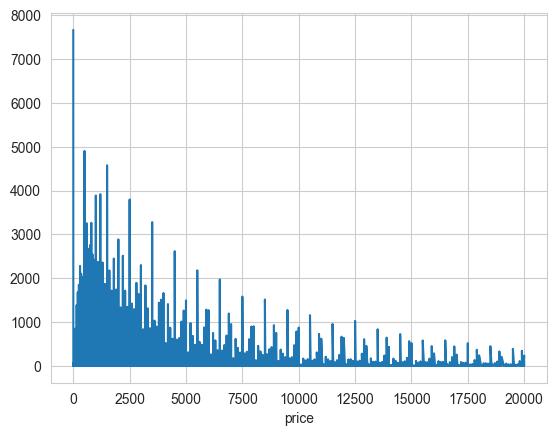

In [42]:
df.groupby('price')['price'].count().plot();

Машины стимостью до 500 евро - редкость на рынке, а вот сверху потолка может и не быть - дорошие машины есть всегда
В price оставим только значения > 500

In [43]:
df = df[(df['price'] >= 500)]
df.shape

(272517, 12)

In [44]:
df['registration_year'].sort_values().unique()

array([1000, 1001, 1400, 1500, 1600, 1602, 1800, 1910, 1923, 1927, 1928,
       1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1941,
       1942, 1943, 1945, 1947, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2290,
       2900, 3700, 4000, 4500, 5000, 5555, 5911, 6000, 7000, 7100, 7800,
       8200, 8500, 9000, 9999])

Год выгрузки объявлений - 2016 год. Т.е нам надо оставить объявления до 2016 года и с 1980 года

In [45]:
df = df[(df['registration_year'] >= 1980) & (df['registration_year'] <= 2016)]
df.shape

(259880, 12)

В датасете встречаются машины с мощностью 0 лс. Возможно, это автомобили без двигателя.
Оставим все значения до 500 лс.

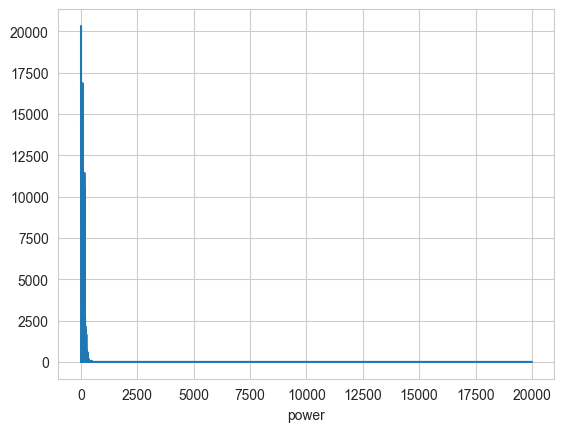

In [46]:
df.groupby('power')['power'].count().plot();

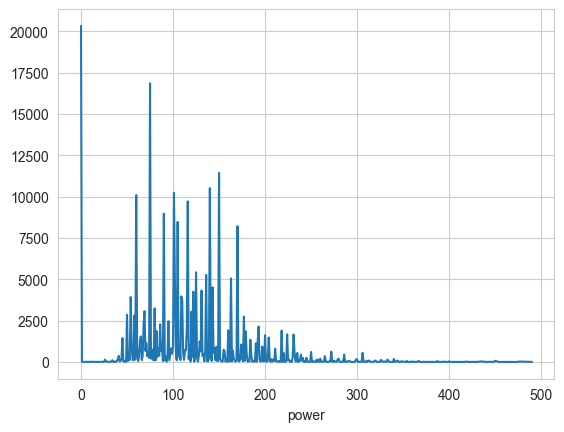

In [47]:
df[df['power']< 500].groupby('power')['power'].count().plot();

In [48]:
df = df[(df['power'] <= 500)]
df.shape

(259578, 12)

In [49]:
df.groupby('registration_month')['registration_month'].count()

registration_month
0     16728
1     17379
2     16080
3     26462
4     22448
5     22259
6     24017
7     20873
8     17378
9     18561
10    20134
11    18807
12    18452
Name: registration_month, dtype: int64

registration_month не может быть равен нулю. поставим наиболее популярный месяц - март

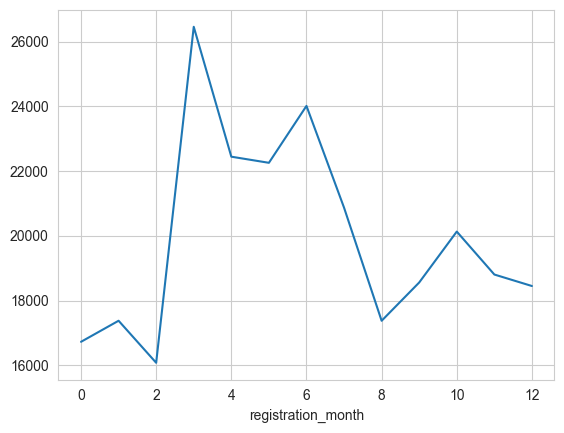

In [50]:
df.groupby('registration_month')['registration_month'].count().plot();

In [51]:
df['registration_month'] = df['registration_month'].replace(0, 3)
df = df.reset_index(drop=True)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,user_interest_days
0,550,small,2001,manual,75,corsa,150000,5,petrol,opel,yes,1
1,9000,sedan,2011,manual,109,c_reihe,90000,3,petrol,volvo,no,2
2,1200,wagon,2000,manual,115,passat,150000,5,petrol,volkswagen,no,3
3,2850,sedan,1990,manual,0,other,150000,2,petrol,mercedes_benz,no,3
4,599,small,1997,manual,50,polo,100000,4,petrol,volkswagen,no,1


Разделим данные на треин и тест для последущего преобразования признаков.

In [52]:
train, i = train_test_split(df, test_size=0.4, random_state=RANDOM_STATE)
test, valid = train_test_split(i, test_size=0.5, random_state=RANDOM_STATE)
train.shape, valid.shape, test.shape

((155746, 12), (51916, 12), (51916, 12))

In [53]:
train_features = train.drop(['price'], axis=1).reset_index(drop=True)
train_target = train['price'].reset_index(drop=True)
test_features = test.drop(['price'], axis=1).reset_index(drop=True)
test_target = test['price'].reset_index(drop=True)
valid_features = valid.drop(['price'], axis=1).reset_index(drop=True)
valid_target = valid['price'].reset_index(drop=True)
train_target.shape, train_features.shape, test_target.shape, test_features.shape, valid_target.shape, valid_features.shape

((155746,), (155746, 11), (51916,), (51916, 11), (51916,), (51916, 11))

Преобразуем категориальный признаки, а так же уберем 1-й признак из закодированных, чтобы избежать dummy-ловушку.

In [54]:
train_features.head(10)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,user_interest_days
0,sedan,2008,manual,109,c4,125000,3,petrol,citroen,no,5
1,wagon,2001,manual,170,3er,150000,2,petrol,bmw,no,3
2,convertible,2008,manual,140,a3,80000,7,petrol,audi,no,3
3,wagon,2006,auto,170,e_klasse,150000,7,petrol,mercedes_benz,yes,13
4,bus,2006,auto,174,transporter,150000,9,petrol,volkswagen,no,23
5,wagon,2005,manual,105,touran,150000,4,petrol,volkswagen,unknown,1
6,small,1997,manual,82,a_klasse,150000,3,petrol,mercedes_benz,no,28
7,suv,2009,manual,141,tucson,150000,1,gas,hyundai,no,5
8,small,1994,manual,55,polo,150000,5,petrol,volkswagen,no,3
9,sedan,2004,manual,116,1er,150000,10,petrol,bmw,unknown,3


In [55]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(train_features[cat_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [56]:
def get_oe_df(df, asd):
    encoded = oe.transform(df[asd])
    encoded_df = pd.DataFrame(encoded, columns=asd)
    df.drop(columns=asd, inplace=True)
    df_oe = pd.concat([df, encoded_df], axis=1)
    return df_oe

In [57]:
train_features_oe = get_oe_df(train_features, cat_features)
train_features_oe.head()

,registration_year,power,kilometer,registration_month,user_interest_days,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,2008,109,125000,3,5,4.0,1.0,57.0,4.0,5.0,0.0
1,2001,170,150000,2,3,7.0,1.0,11.0,4.0,2.0,0.0
2,2008,140,80000,7,3,1.0,1.0,28.0,4.0,1.0,0.0
3,2006,170,150000,7,13,7.0,0.0,95.0,4.0,20.0,2.0
4,2006,174,150000,9,23,0.0,0.0,221.0,4.0,37.0,0.0


In [58]:
valid_features_oe = get_oe_df(valid_features, cat_features)
valid_features_oe.head()

,registration_year,power,kilometer,registration_month,user_interest_days,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,2007,88,150000,3,19,5.0,1.0,75.0,1.0,27.0,0.0
1,1997,54,150000,4,1,0.0,1.0,166.0,4.0,33.0,0.0
2,1999,88,150000,5,34,7.0,1.0,10.0,4.0,19.0,1.0
3,2000,144,150000,4,14,4.0,0.0,164.0,4.0,24.0,1.0
4,2000,163,90000,3,7,4.0,0.0,59.0,4.0,20.0,0.0


In [59]:
test_features_oe = get_oe_df(test_features, cat_features)
test_features_oe.head()

,registration_year,power,kilometer,registration_month,user_interest_days,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,2004,150,150000,2,5,4.0,0.0,11.0,4.0,2.0,1.0
1,2016,75,150000,3,1,3.0,1.0,173.0,4.0,37.0,1.0
2,2007,143,150000,12,13,4.0,1.0,11.0,4.0,2.0,0.0
3,2001,60,100000,10,19,1.0,1.0,101.0,4.0,31.0,0.0
4,2002,50,150000,12,1,5.0,1.0,143.0,4.0,37.0,2.0


Масштабируем количественные признаки

In [60]:
columns = ['registration_year', 'power', 'kilometer', 'user_interest_days']

scaler = StandardScaler()
scaler.fit(train_features_oe[columns])

train_features_oe[columns] = scaler.transform(train_features_oe[columns])
valid_features_oe[columns] = scaler.transform(valid_features_oe[columns])
test_features_oe[columns] = scaler.transform(test_features_oe[columns])
train_features_oe.head()

,registration_year,power,kilometer,registration_month,user_interest_days,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,0.812763,-0.070764,-0.087399,3,-0.583589,4.0,1.0,57.0,4.0,5.0,0.0
1,-0.383130,0.937761,0.592594,2,-0.812967,7.0,1.0,11.0,4.0,2.0,0.0
2,0.812763,0.441765,-1.311387,7,-0.812967,1.0,1.0,28.0,4.0,1.0,0.0
3,0.471079,0.937761,0.592594,7,0.333925,7.0,0.0,95.0,4.0,20.0,2.0
4,0.471079,1.003894,0.592594,9,1.480816,0.0,0.0,221.0,4.0,37.0,0.0


## Обучение моделей

In [61]:
def score(model, params, X, y):
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=3)
    grid.fit(X, y)
    print(f'rmse {model} = {(-grid.best_score_) ** 0.5}')
    print(f'best params {grid.best_params_}')
    d = grid.best_params_
    return d

In [62]:
dt = DecisionTreeRegressor()
dt_params = {'max_leaf_nodes': [15, 19],
             'max_depth': [6, 10],
             'min_samples_leaf': [3, 5]}

rf = RandomForestRegressor()
rf_params = {'n_estimators': [100, 150],
             'max_depth': [5, 8],
             'min_samples_leaf': [2, 5]}

lgbm = LGBMRegressor()

lgbm_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
}

In [63]:
%%time
dt_best_params = score(dt, dt_params, train_features_oe, train_target)

rmse DecisionTreeRegressor() = 2497.1325649676073
best params {'max_depth': 6, 'max_leaf_nodes': 19, 'min_samples_leaf': 3}
CPU times: user 4.11 s, sys: 291 ms, total: 4.4 s
Wall time: 4.45 s


In [64]:
%%time
rf_best_params = score(rf, rf_params, train_features_oe, train_target)

rmse RandomForestRegressor() = 2008.2354209102175
best params {'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 150}
CPU times: user 7min 52s, sys: 4.14 s, total: 7min 56s
Wall time: 8min 3s


Так как модель градиентного бустинга запускается долго, применим не гридсерч а рандомайз серч

In [65]:
%%time
a = RandomizedSearchCV(lgbm, lgbm_params, scoring='neg_mean_squared_error', cv=3)
a.fit(train_features_oe, train_target)
lgbm_best_params = a.best_params_

print(f'rmse {lgbm} = {(-a.best_score_) ** 0.5}')
print(f'best params {a.best_params_}')

rmse LGBMRegressor() = 1573.4337668855535
best params {'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.3}
CPU times: user 1min 14s, sys: 3.16 s, total: 1min 17s
Wall time: 21.1 s


Лучшие значения метрик у моделей дерево решений, случайный лес и lgbm

## Анализ моделей

Сравним время обучения этих трех моделей

In [66]:
%%time
model_dt = DecisionTreeRegressor(max_depth=6, max_leaf_nodes=19, min_samples_leaf=3, random_state=RANDOM_STATE)
model_dt.fit(train_features_oe, train_target)

CPU times: user 483 ms, sys: 83.3 ms, total: 566 ms
Wall time: 349 ms


DecisionTreeRegressor(max_depth=6, max_leaf_nodes=19, min_samples_leaf=3,
                      random_state=12345)

In [67]:
%%time
model_rf = RandomForestRegressor(max_depth=8, min_samples_leaf=2, n_estimators=100, random_state=RANDOM_STATE)
model_rf.fit(train_features_oe, train_target)

CPU times: user 26.7 s, sys: 115 ms, total: 26.8 s
Wall time: 27.2 s


RandomForestRegressor(max_depth=8, min_samples_leaf=2, random_state=12345)

In [68]:
%%time
model_lgbm = LGBMRegressor(n_estimators=200, max_depth=12, learning_rate=0.3, random_state=RANDOM_STATE)
model_lgbm.fit(train_features_oe, train_target)

CPU times: user 3.74 s, sys: 177 ms, total: 3.92 s
Wall time: 1.24 s


LGBMRegressor(learning_rate=0.3, max_depth=12, n_estimators=200,
              random_state=12345)

Быстрее всего обучается модель дерево решений и случайный лес  
Сравним время предсказания моделей

In [69]:
%%time
dt_train_preds = model_dt.predict(train_features_oe)

CPU times: user 56.6 ms, sys: 24 ms, total: 80.6 ms
Wall time: 38.2 ms


In [70]:
%%time
rf_train_preds = model_rf.predict(train_features_oe)

CPU times: user 1.05 s, sys: 27.4 ms, total: 1.08 s
Wall time: 1.05 s


In [71]:
%%time
lgbm_train_preds = model_lgbm.predict(train_features_oe)

CPU times: user 2.8 s, sys: 24.6 ms, total: 2.82 s
Wall time: 852 ms


Быстрее всего предсказывает модель дерево решений и случайеый лес  
Проверим модели на валидационной выборке, чтобы получить значения метрики и сравнить качество моделей

In [72]:
dt_valid_preds = model_dt.predict(valid_features_oe)
print(f'RMSE dt train:{abs(mean_squared_error(train_target, dt_train_preds)) **0.5}\n'
      f'RMSE dt valid: {abs(mean_squared_error(valid_target, dt_valid_preds)) ** 0.5}')

RMSE dt train:2489.0456448869654
RMSE dt valid: 2477.1815501676665


In [73]:
rf_valid_preds = model_rf.predict(valid_features_oe)
print(f'RMSE rf train:{abs(mean_squared_error(train_target, rf_train_preds)) **0.5}\n'
      f'RMSE rf: {abs(mean_squared_error(valid_target, rf_valid_preds)) ** 0.5}')

RMSE rf train:1977.7251807404546
RMSE rf: 1994.3240596837825


In [74]:
lgbm_valid_preds = model_lgbm.predict(valid_features_oe)
print(f'RMSE lgbm train:{abs(mean_squared_error(train_target, lgbm_train_preds)) **0.5}\n'
      f'RMSE lgbm: {abs(mean_squared_error(valid_target, lgbm_valid_preds)) ** 0.5}')

RMSE lgbm train:1393.0351219049385
RMSE lgbm: 1525.7708407368227


Лучшую метрику показывает lgbm- модель

Так как у нас есть требования и к скорости обучения и к скорости предсказания и к качеству модели, выберем деревья с градиентным бустингом. Протестируем эту модель на тестовых данных.

In [77]:
print(f'RMSE lgbm test: {abs(mean_squared_error(test_target, model_lgbm.predict(test_features_oe))) ** 0.5}')

RMSE lgbm test: 1529.0086735036639


Модель деревья решений с градиентным бустингом показывает почти такое же значение метрики на тестовых данных, как и на валидационной выборке.

Посмотрим, какие признаки оказались наиболее важными для принятия решений моделью.

Feature 1: 1182.00
Feature 2: 1288.00
Feature 3: 442.00
Feature 4: 286.00
Feature 5: 473.00
Feature 6: 468.00
Feature 7: 129.00
Feature 8: 909.00
Feature 9: 33.00
Feature 10: 665.00
Feature 11: 125.00


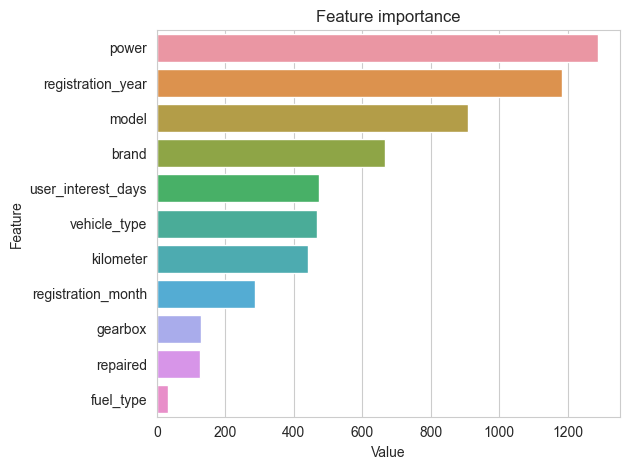

In [78]:
feature_importances = model_lgbm.feature_importances_
for i, importance in enumerate(feature_importances):
    print(f"Feature {i+1}: {importance:.2f}")

feature_names = train_features_oe.columns.tolist()

feature_importance = model_lgbm.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, train_features_oe.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

Важными признаками для принятия решений модели дерево решений, в порядке убывания важности являются  мощность (л.с), год регистрации автомобиля, модель авто, брэнд.

Таким образом, мы решили поставленную задачу - построили модель для определения рыночной стоимости автомобиля клиента с метрикой RMSE менее 2500.

Нами были проведены знакомство с данными, их предобработка (удаление дубликатов, заполнение пропусков, устранение аномальных данных). Во многих количествееных данных были обнаружены нулевые значения. Возможно, в поле есть дефолтное значение, а поле ввода не является обязательным на сайте, поэтому эти данные не вошли в обучающую выборку и были удалены.
Мы преобразовали категориальные признаки методом OrdinalEncoder и масштабировали количественные признаки методом стандартизации. 
Для решения задачи были выбраны три модели - дерево решений, ансамбль деревьев (модель случайного леса) и модель ансамбля стохастического градиентного бустинга lgbm. 
Критерии, которые нам важны: качество предсказания, время обучения модели, время предсказания модели.
К сожалению, не нашлась модель, лучашая по всем трем критериям, но самой лучшей с точки зрения метрики оказалась модель lgbm. С параметрами n_estimators=200, max_depth=12, learning_rate=0.3